# Projecting COVID-19 hospital use in Ottawa

In [1]:
cd ..

/Users/warsameyusuf/Documents/Masters/Research project/Git files BLL/chime_sims


In [2]:
# Import functions and import simulated data

import pandas as pd
from os import getcwd, path, sys
from _99_shared_functions import *
import matplotlib.pyplot as plt
from scipy import stats as sps

import sys
pd.options.display.max_rows = 400
pd.options.display.max_columns = 400

# For getting the last folder containing hospital name
def get_all_folders(path):
    return [x for x in os.listdir(path) if os.path.isfile(x) == False]

# Get parameters from files stored during step 1, don't get from args (one argument, directory)
datadir = path.join(f'{getcwd()}', 'data')
outdir = path.join(f'{getcwd()}', 'output')
lastdir = path.join(f'{get_all_folders(outdir)[-1]}')
outdir = path.join(f'{lastdir}', 'output')
figdir = path.join(f'{lastdir}', 'figures')


hospital = 'OTT'

census_ts = pd.read_csv(path.join(f"{datadir}",f"{hospital}_ts.csv"))
first_day = census_ts['date'].values[0]
params = pd.read_csv(path.join(f"{datadir}",f"{hospital}_parameters.csv"))
# impute vent with the proportion of hosp.  this is a crude hack
census_ts.loc[census_ts.vent.isna(), 'vent'] = census_ts.hosp.loc[census_ts.vent.isna()]*np.mean(census_ts.vent/census_ts.hosp)

# This needs to be configuable based on the time period specificed 
nobs = census_ts.shape[0]

# define capacity
vent_capacity = float(params.base.loc[params.param == 'vent_capacity'])
hosp_capacity = float(params.base.loc[params.param == 'hosp_capacity'])

# Chains
df = pd.read_json(path.join('output',f"{outdir}","chains.json.bz2"), lines = True)

# remove burn-in
# Make 1000 configurable
df = df.loc[(df.iter>1000)] #& (~df.chain.isin([1, 12]))]

In [3]:
# Define predictive plot function 

def plt_predictive_panel(arrq, column, label, dates, howfar,  axx):
    axx.plot_date(dates, arrq[2,:howfar, column], '-', label = 'posterior median')
    axx.set_ylabel(label, fontsize=12, fontweight='bold')
    axx.fill_between(x = dates,
                       y1 = arrq[0,:howfar,column],
                       y2 = arrq[4,:howfar,column], 
                       label = '90% Credible Region',
                       alpha = .1,
                       lw = 2,
                       edgecolor = "k")
    axx.fill_between(x = dates,
                       y1 = arrq[1,:howfar,column],
                       y2 = arrq[3,:howfar,column], 
                       label = '50% Credible Region',
                       alpha = .1,
                       lw = 2,
                       edgecolor = "k")
    axx.legend()
    axx.grid(True)

def plt_predictive(howfar=200, df = df):
    # predictive plot
    arrs = np.stack([df.arr.iloc[i] for i in range(df.shape[0])])
    arrq = np.quantile(arrs, axis = 0, q = [.05, .25, .5, .75, .95])

    dates = pd.date_range(f'{first_day}',
        periods=howfar, freq='d')
    fig, ax = plt.subplots(figsize=(16, 10), ncols=2, nrows=2, sharex=True)
    
    # hosp
    axx = ax[0,0]
    plt_predictive_panel(arrq, 3, "COVID-19 Hospital census", dates, howfar,  axx)
    axx.axhline(y=hosp_capacity, color='k', ls='--', label = "hospital capacity")
    axx.plot_date(dates[:census_ts.hosp.shape[0]], census_ts.hosp, '-',
               color = "red",
               label = "observed")

    axx = ax[0,1]
    plt_predictive_panel(arrq, 5, "COVID-19 Vent census", dates, howfar,  axx)
    axx.axhline(y=vent_capacity, color='k', ls='--', label = "vent capacity")
    axx.plot_date(dates[:census_ts.vent.shape[0]], census_ts.vent, '-',
               color = "red",
               label = "observed")
    axx.legend()
    axx.grid(True)

    # Admits
    axx = ax[1,0]
    plt_predictive_panel(arrq, 0, "COVID-19 Hospital Admits", dates, howfar,  axx)

    axx = ax[1,1]
    plt_predictive_panel(arrq, 2, "COVID-19 Vent Admits", dates, howfar,  axx)
    fig.autofmt_xdate()
    fig.tight_layout()

## Using reopen_loop() to project COVID-19 hospitalization with various reopening scenarios

Using reopen_loop(df = df, reopen_on_days = [0], today = 45, reopen_speed= 0.03, sd_percent_change=1) you can project what COVID-19 hospitalizations will look like with various changes in distancing.

sd_percent_change is the change in distancing relative to current distancing measures. sd_percent_change = 1 represents current distancing, with values less than 1 representing decreased distancing and values greater than 1 representing increased distancing.

In [4]:
def reopen_loop(df = df, reopen_on_days = [0], today = 45, reopen_speed= 0.03, sd_percent_change=1):
    reopen_sims = {}
    for reopen_on in reopen_on_days:
        df['reopen_day'] = today + reopen_on # begin reopening in reopen_on days from now
        df['reopen_speed'] = reopen_speed
        df.index = range(df.shape[0])
        ddf = df.T.reset_index()

        sims = []
        idx_samples = np.random.choice([i for i in df.index], 4000)
        for param_col in idx_samples:
            p_df = ddf[['index', param_col]].rename(columns={'index': 'param', param_col: 'val'})
            sim = SIR_from_params(p_df, sd_percent_change=sd_percent_change)
            sims.append(sim)
        df_reopen = pd.DataFrame(sims)
        reopen_sims[reopen_on] = df_reopen
    return df_reopen

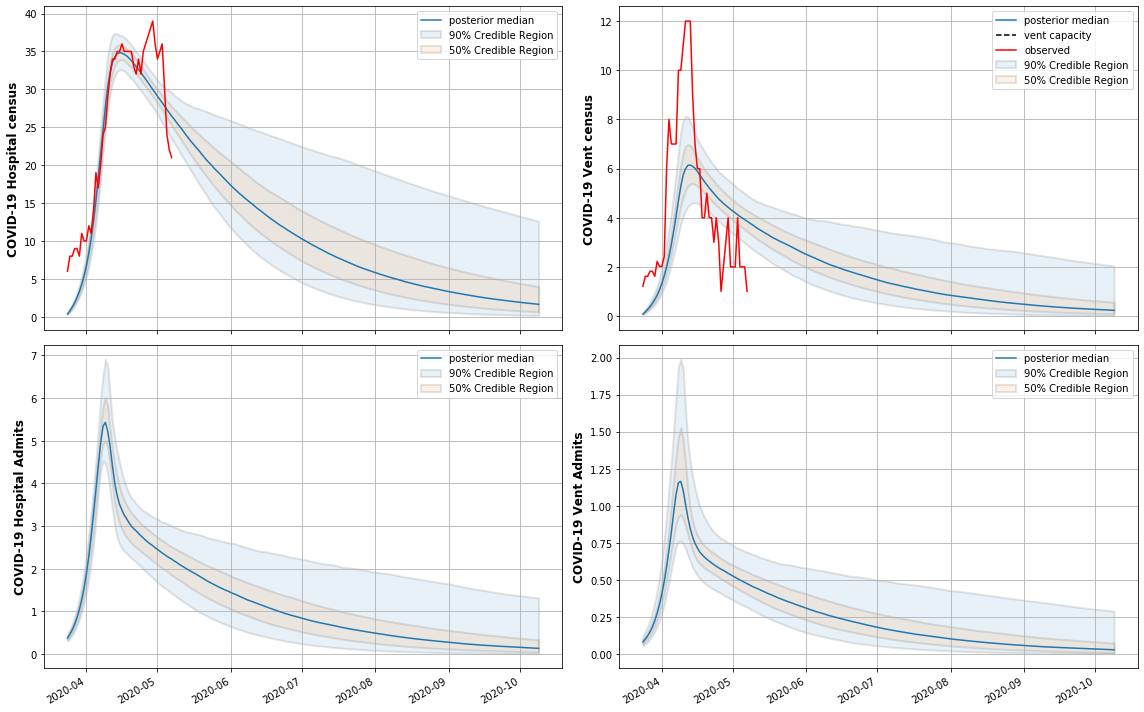

In [5]:
df_reopen = reopen_loop(df, [0], 45, 0.03, sd_percent_change= 1)
plt_predictive(200, df_reopen)

## Exporting projections as a CSV file

Using create_predctive_csv() you can create a dataframe that can be exported as a CSV. Within the function you can set your percent change parameters using reopen_loop().

In [6]:
def create_predictive_csv():
    # set current parameters here
    current_df = reopen_loop(df = df, reopen_on_days = [0], today = 45, reopen_speed= 0.03, sd_percent_change=1.1)
    # set percent change here
    reduction_20 = reopen_loop(df = df, reopen_on_days = [0], today = 45, reopen_speed= 0.03, sd_percent_change=0.9)
    final_df = export_csv(200, [current_df,reduction_20], suffix = ["current","reduction_20"])
    return final_df


def export_csv (howfar=200, df_ar = [df], suffix = [""]):
    dataframe_dictionary = {}
    final_dataframe = pd.DataFrame()
    index = 0
    for df in df_ar: 
        arrs = np.stack([df.arr.iloc[i] for i in range(df.shape[0])])
        arrq = np.quantile(arrs, axis = 0, q = [.05, .25, .5, .75, .95])

        dates = pd.date_range(f'{first_day}',
            periods=howfar, freq='d')
        hosp_census = create_csv_export_dataframe(arrq, 3, "hosp_census", dates, howfar, suffix[index])
        vent_census = create_csv_export_dataframe(arrq, 5, "vent_census", dates, howfar, suffix[index])
        hosp_admits = create_csv_export_dataframe(arrq, 0, "hosp_admits", dates, howfar, suffix[index])
        vent_admits = create_csv_export_dataframe(arrq, 2, "vent_admits", dates, howfar, suffix[index])
        tmp_combine_census = pd.merge(hosp_census,vent_census, on = "date")
        tmp_combine_admits = pd.merge(hosp_admits,vent_admits, on = "date")
        tmp_combine = pd.merge(tmp_combine_census,tmp_combine_admits, on = "date")
        if final_dataframe.size == 0:
            final_dataframe = tmp_combine
        else:
            final_dataframe = pd.merge(final_dataframe, tmp_combine, on = "date")
        index = index+1
    return final_dataframe

def create_csv_export_dataframe (arrq, column, name, dates, howfar, suffix):
    dataframe_dictionary = {'date': dates, f'{name}_5_{suffix}':arrq[0,:howfar,column], f'{name}_95_{suffix}':arrq[4,:howfar,column], f'{name}_median_{suffix}':arrq[2,:howfar, column]}
    dataframe = pd.DataFrame(data=dataframe_dictionary)
    return dataframe


In [7]:
combined_data = create_predictive_csv()

In [8]:
combined_data.to_csv('combined_data.csv',index=False)